# **Siamese Network using face dataset, using MTCNN to detect face**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Load data:**

In [ ]:
!unzip /content/gdrive/Shareddrives/data_face_HUS/data_face_HUS.zip -d "/content/"

**Install MTCNN**

In [3]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.5 MB/s eta 0:00:00


**Import all neeeded libraries and preprocess using MTCNN**

In [ ]:
import os
import glob
import cv2
import numpy as np
from mtcnn import MTCNN

detector = MTCNN()

folder_path = 'data_face_HUS/*/*'

# Find all files in subfolders
files = glob.glob(folder_path, recursive=True)

# Categorize files based on subfolder name
categories = {}

for file in files:
    subfolder = os.path.basename(os.path.dirname(file))
    if subfolder in categories:
        categories[subfolder].append(file)
    else:
        categories[subfolder] = [file]

X_train_label = []
X_train_list = []
X_test_label = []
X_test_list = []
for category, files in categories.items():
    # print(category)
    # for file in files:
    #     print('\t', file)
    train_list = glob.glob('data_face_HUS/'+category+'/*')
    for name in train_list:
        img = cv2.imread(name)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = detector.detect_faces(img_rgb)
            if results:
              # Extract face
              x1, y1, width, height = results[0]['box']
              x2, y2 = x1 + width, y1 + height
              face = img_rgb[y1:y2, x1:x2]
              face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
              face = cv2.resize(face, (96,96))
              X_train_list.append(face)
              X_train_label.append(category)

**Divide into train and test**

In [5]:
X_train = np.array(X_train_list)
y_train = np.array(X_train_label)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(873, 96, 96)
(219, 96, 96)
(873,)


**Build model CNN**

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

inp = Input(shape=(96,96,1))
x = Conv2D(filters = 8, kernel_size = 3, activation = 'relu')(inp)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Flatten()(x)
x = Dense(units = 32, activation = 'relu')(x)
x = Dense(units = 2)(x)

cnn = Model(inputs = inp, outputs = x)
img1 = Input(shape = (96,96,1))
img2 = Input(shape = (96,96,1))

f1 = cnn(img1)
f2 = cnn(img2)

d = K.sqrt(K.sum(K.square(f1 - f2),axis = 1, keepdims = True))

model = Model(inputs = [img1,img2], outputs = d)
model.summary()
cnn.summary()

def loss1(y_true, y_pred):
  return K.mean(y_true * K.square(y_pred) + (1-y_true) * K.square(K.maximum(1.0 - y_pred, 0)))

model.compile(optimizer = 'adam', loss = loss1)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 model_3 (Functional)           (None, 2)            565682      ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 2)            0           ['model_3[0][0]',          

**Make all pairs or other strategies; some innovation here**

Batch size:  848
(96, 96, 1)
Pair label: 1.0


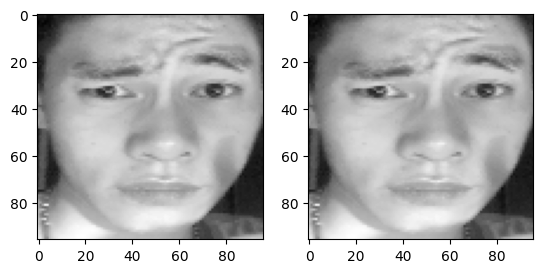

In [8]:
import numpy as np
from matplotlib import pyplot as plt

def generator(X,y,k = 8):
  unique_labels = np.unique(y)

  while True:
    X1 = []
    X2 = []
    y_batch = []
    for label in unique_labels:
      label_idx = np.where(y == label)[0]
      other_labels = set(unique_labels) - {label}

      for i in range(k):
        i1 = np.random.choice(label_idx)
        i2 = np.random.choice(label_idx)
        # i1 must be different from i2
        # while i1 == i2:
        #   i2 = np.random.choice(label_idx)
        # create positive example
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(1.0)

        # create negative example
        i1 = np.random.choice(label_idx)
        my_label = np.random.choice(list(other_labels))
        i2 = np.random.choice(list(np.where(y == my_label)[0]))
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(0.0)
    yield [np.array(X1) / 255., np.array(X2) / 255.], np.array(y_batch)

# For testing
for pair, y in generator(X_test, y_test):
  print('Batch size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print(pair[0][idx].shape)
  print('Pair label:', y[idx])
  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(96,96), cmap = 'gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(96,96), cmap = 'gray')

  break

**Fit model**

In [9]:
history = model.fit(generator(X_train, y_train, k = 32),
                    steps_per_epoch = 10,
                    epochs = 4,
                    validation_data = generator(X_test, y_test, k = 8),
                    validation_steps = 5)

Epoch 1/4
10/10 [==============================] - 43s 3s/step - loss: 0.1646 - val_loss: 0.1119
Epoch 2/4
10/10 [==============================] - 43s 5s/step - loss: 0.0875 - val_loss: 0.1019
Epoch 3/4
10/10 [==============================] - 46s 5s/step - loss: 0.0580 - val_loss: 0.1065
Epoch 4/4
10/10 [==============================] - 27s 3s/step - loss: 0.0440 - val_loss: 0.1110


**Visualize learning process**

Text(0, 0.5, 'Loss')

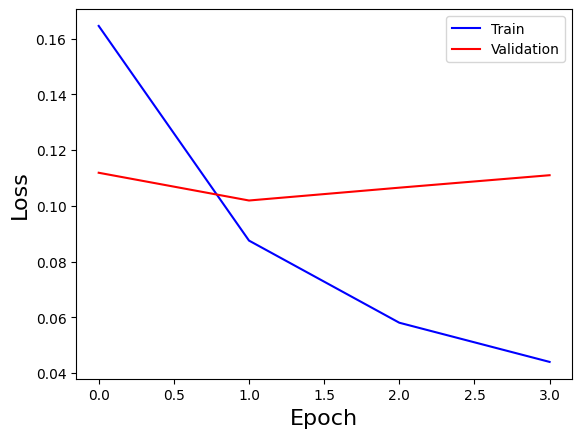

In [10]:
plt.plot(history.history['loss'], label = 'Train', c = 'b')
plt.plot(history.history['val_loss'], label = 'Validation', c = 'r')
plt.legend()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

27/27 [==============================] - 0s 4ms/step
Batch_size:  848
Pair label: 0.0
Distance: [1.000151]
Distance by features: [1.000152]


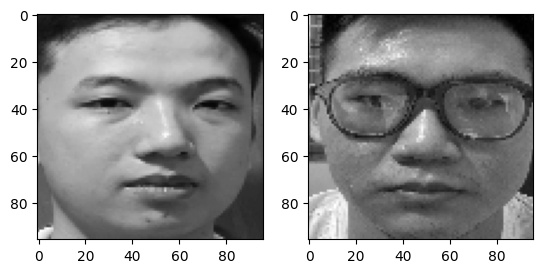

In [25]:
for pair, y in generator(X_test, y_test):
  y_pred = model.predict(pair)
  print('Batch_size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print('Pair label:', y[idx])
  print('Distance:', y_pred[idx])

  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2,axis = 1, keepdims = True))
  print('Distance by features:', d[idx])

  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(96,96),cmap = 'gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(96,96),cmap = 'gray')
  break

**Visualize new feature space**

In [17]:
f = cnn.predict(X_test/255.)
# p = plt.scatter(f[:,0],f[:,1], c = y_test, s=1)
# plt.colorbar(p)

7/7 [==============================] - 0s 2ms/step


**Save model**

In [18]:
cnn.save('cnn_loss1.h5')

**Load model and test**

In [19]:
from tensorflow.keras.models import load_model
m = load_model('cnn_loss1.h5')

f1 = m.predict(X_test / 255.)
# p = plt.scatter(f1[:,0],f1[:,1],c=y_test,s=1)
# plt.colorbar(p)

7/7 [==============================] - 0s 2ms/step


**Visualize negative distance and positive distance**

In [21]:
i = 0
y_true = []
y_pred = []
for pair,y in generator(X_test,y_test):
  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1 - f2)**2, axis = 1, keepdims = True))
  y_pred +=list(d.ravel())
  y_true +=list(y)
  i+=1
  if i>500:
    break

**Plot histogram**

(array([0.07151655, 0.18194477, 0.32319286, 0.44468775, 0.48438493,
        0.53928934, 0.53376825, 0.5403365 , 0.44954291, 0.38464252,
        0.34268455, 0.23551665, 0.17454316, 0.13484613, 0.09422105,
        0.06092589, 0.02941578, 0.01254217, 0.01063824, 0.00687796]),
 array([0.00444114, 0.2022448 , 0.40004846, 0.59785217, 0.79565585,
        0.99345946, 1.1912632 , 1.38906682, 1.58687055, 1.78467417,
        1.98247778, 2.1802814 , 2.37808514, 2.57588887, 2.77369261,
        2.97149611, 3.16929984, 3.36710358, 3.56490731, 3.76271081,
        3.96051455]),
 <BarContainer object of 20 artists>)

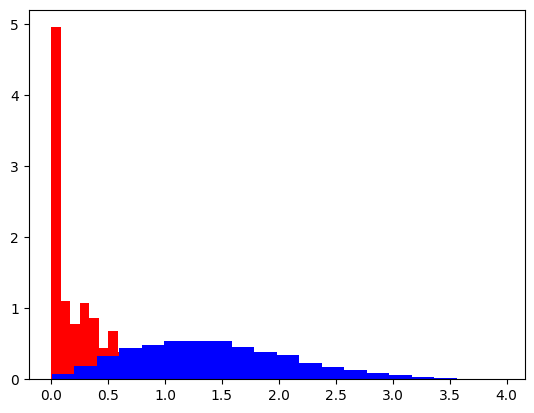

In [22]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

positive_distances = y_pred[y_true == 1]
negative_distances = y_pred[y_true == 0]

plt.hist(positive_distances, color = 'r', density = True, bins = 20)
plt.hist(negative_distances, color = 'b', density = True, bins = 20)

**Check report using sklearn**

In [23]:
thresh = 0.5
y_pred_ = y_pred < thresh
y_pred_.astype('uint8')
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_))

              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86    212424
         1.0       0.91      0.77      0.83    212424

    accuracy                           0.84    424848
   macro avg       0.85      0.84      0.84    424848
weighted avg       0.85      0.84      0.84    424848

